# Workflow

## Goal
Determine which was the best classification method for determining whether a university was in the Northeast or the West

## Steps
1. General exploratory data analysis
2. Data cleaning (handling missing values)
3. Feature selection
4. Data cleaning (get dummies)
5. Run and optimize models
6. Evaluate models
7. Feature selection again
8. Repeat steps 5 and 6
9. Select final model

## Models Used
* **Dummy Classifier**
    + Using scikit-learn's dummy classifier with a stratified strategy
* **K-Nearest Neighbors**
    + Scaled variables
    + k = 1
* **Optimized K-Nearest Neighbors**
    + Evaluate using F1 score for k 1-25
    + k = 3
* **Decision Tree**
    + max_depth = 2
* **Optimized Decision Tree (max_depth)**
    + Evalute using F1 score for max_depth 1-10
    + max_depth = 8
* **Optimized Decision Tree (criterion, max_depth, min_samples_split)**
    + Evaluate using GridSearchCV
    + criterion = entropy
    + max_depth = 10
    + min_samples_split = 2
* **Random Forest**
    + n_estimators = 100
    + max_depth = 2
* **Optimized Random Forest (n_estimators, criterion, max_depth, min_samples_split)**
    + Evaluate using GridSearchCV
    + criterion = entropy
    + max_depth = 10
    + min_sample_split = 5
    + n_estimators = 125
* **AdaBoost**
    + n_estimators = 100
* **Optimized AdaBoost (n_estimators)**
    + Evaluate using cross validation score
    + n_estimators = 175
* **XGBoost**
* **Optimized XGBoost**
    + Evaluate using GridSearchCV
    + learning_rate = 0.1
    + max_depth = 6
    + min_child_weight = 1
    + n_estimators = 100
    + subsample = 0.5

## Final Model

Based on accuracy, precision, recall, F1-score, and interpretability, the final model I selected was the optimized random forest

# Import Packages

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
import itertools

# Import Classifiers & Packages for Modeling

In [63]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, precision_score, recall_score
from sklearn.metrics import auc, roc_curve
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split

from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier

from IPython.display import Image  
from pydotplus import graph_from_dot_data

# Load Data

In [12]:
ipeds_data = pd.read_csv('ipeds_new_data.csv')
ipeds_data.drop('Unnamed: 0', axis = 1, inplace = True)
ipeds_data.head()

,unitid,inst_name,state_abbr,region,urban_centric_locale,title_iv_indicator,inst_control,institution_level,inst_category,inst_size,...,cb_region,headcount_asn_Total_prop,headcount_blk_Total_prop,headcount_hsp_Total_prop,headcount_hwnpi_Total_prop,headcount_mlt_Total_prop,headcount_nonres_Total_prop,headcount_ntv_Total_prop,headcount_unknown_Total_prop,headcount_wht_Total_prop
0,102553.0,University of Alaska Anchorage,AK,8.0,11.0,1.0,1.0,4.0,2.0,4.0,...,West,0.060485,0.030683,0.070895,0.006632,0.086845,0.015237,0.064473,0.072448,0.592302
1,102614.0,University of Alaska Fairbanks,AK,8.0,23.0,1.0,1.0,4.0,2.0,3.0,...,West,0.018203,0.022080,0.054947,0.008680,0.052419,0.011377,0.200067,0.181864,0.450362
2,102632.0,University of Alaska Southeast,AK,8.0,33.0,1.0,1.0,4.0,2.0,2.0,...,West,0.035880,0.011100,0.055756,0.007486,0.070986,0.009293,0.119773,0.156686,0.533041
3,102845.0,Charter College,WA,8.0,12.0,1.0,3.0,4.0,3.0,2.0,...,West,0.002653,0.062776,0.269231,0.055040,0.049735,0.000000,0.101459,0.055261,0.403846
4,103945.0,CollegeAmerica-Flagstaff,AZ,6.0,13.0,1.0,2.0,4.0,3.0,1.0,...,West,0.000000,0.022059,0.058824,0.007353,0.132353,0.000000,0.558824,0.000000,0.220588


In [13]:
ipeds_data.columns.values

array(['unitid', 'inst_name', 'state_abbr', 'region',
       'urban_centric_locale', 'title_iv_indicator', 'inst_control',
       'institution_level', 'inst_category', 'inst_size', 'sector',
       'hbcu', 'hospital', 'medical_degree', 'tribal_college',
       'land_grant', 'offering_highest_degree', 'offering_highest_level',
       'offering_grad', 'cc_basic_2015', 'cc_instruc_undergrad_2015',
       'cc_enroll_2015', 'cc_size_setting_2015', 'inst_affiliation',
       'occupational_prog_offered', 'academic_prog_offered',
       'avocational_prog_offered', 'remedial_prog_offered',
       'secondary_prog_offered', 'assoc_offered', 'bach_offered',
       'postbac_cert_offered', 'masters_offered',
       'doctors_research_offered', 'doctors_professional_offered',
       'doctors_other_offered', 'remedial_services',
       'academic_counseling', 'employment_services', 'placement_services',
       'oncampus_daycare', 'oncampus_housing', 'oncampus_required',
       'meal_plan', 'tuition_vari

# Make Dummy Variables

In [14]:
dummy_vars = ['institution_level', 'inst_control', 'inst_category', 'inst_size', 
              'tuition_varies', 'study_abroad', 'yellow_ribbon_program', 
              'weekend_evening_college', 'oncampus_housing', 'rotc']
cont_vars = ['headcount_blk_Total_prop', 'headcount_hsp_Total_prop', 
             'headcount_wht_Total_prop', 'headcount_hwnpi_Total_prop', 
             'headcount_ntv_Total_prop', 'headcount_asn_Total_prop', 
             'lowincome_pct', 'fafsa_sent_2ormore_pct', 
             'independent_pct', 'first_gen_student_pct', 'faminc_mean']

In [26]:
dummies = ipeds_data[dummy_vars].astype('str')
cont = ipeds_data[cont_vars]
X = pd.get_dummies(pd.concat([dummies, cont], axis = 1), drop_first = True)
y = ipeds_data['cb_region'].replace({'Northeast': 0, 'West': 1})

# Train, Test, Split

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42) 

## Define Helper Function

In [80]:
regions = ['Northeast', 'West']
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion Matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 1.21
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color = "white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

In [65]:
# Returns dataframe of accuracy, precision, recall, and f1 score for training and testing data
def get_metrics(train_pred, test_pred):
    train_accuracy = accuracy_score(y_train, train_pred)
    test_accuracy = accuracy_score(y_test, test_pred)

    train_precision = precision_score(y_train, train_pred)
    test_precision = precision_score(y_test, test_pred)

    train_recall = recall_score(y_train, train_pred)
    test_recall = recall_score(y_test, test_pred)

    train_f1 = f1_score(y_train, train_pred, average='weighted')
    test_f1 = f1_score(y_test, test_pred, average='weighted')
    
    train_metrics = [train_accuracy * 100, train_precision * 100, 
                     train_recall * 100, train_f1 * 100]
    test_metrics = [test_accuracy * 100, test_precision * 100, 
                    test_recall * 100, test_f1 * 100]
    
    metrics = pd.DataFrame([train_metrics, test_metrics])
    metrics.index = ['Training Data', 'Testing Data']
    metrics.columns = ['Accuracy (%)', 'Precision (%)', 'Recall (%)', 'F1 Score (%)']
    
    return metrics

In [79]:
def plot_feature_importances(model):
    n_features = X_train.shape[1]
    plt.figure(figsize=(8,8))
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), X_train.columns.values) 
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature')

# UNSCALED MODELS

# Baseline Model: Dummy Classifier (F1 = 0.45)

In [29]:
dummy_clf = DummyClassifier(strategy = 'stratified', random_state = 42)
dummy_clf.fit(X_train, y_train)

# Predictions for train and test data
dummy_y_train_pred = dummy_clf.predict(X_train)
dummy_y_test_pred = dummy_clf.predict(X_test)

# Print classification reports
print(classification_report(y_train, dummy_y_train_pred))
print(classification_report(y_test, dummy_y_test_pred))

              precision    recall  f1-score   support

           0       0.52      0.52      0.52       392
           1       0.53      0.52      0.52       398

    accuracy                           0.52       790
   macro avg       0.52      0.52      0.52       790
weighted avg       0.52      0.52      0.52       790

              precision    recall  f1-score   support

           0       0.47      0.47      0.47       174
           1       0.44      0.44      0.44       165

    accuracy                           0.45       339
   macro avg       0.45      0.45      0.45       339
weighted avg       0.45      0.45      0.45       339



In [66]:
# Print evaluation metrics
dummy_metrics = get_metrics(dummy_y_train_pred, dummy_y_test_pred)
dummy_metrics

,Accuracy (%),Precision (%),Recall (%),F1 Score (%)
Training Data,52.151899,52.525253,52.261307,52.152512
Testing Data,45.427729,43.975904,44.242424,45.431530


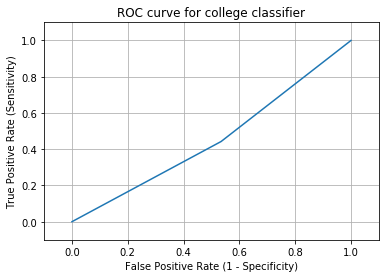

In [77]:
# First calculate the probability scores of each of the datapoints:
y_score = dummy_clf.fit(X_train, y_train).predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_score)
plt.plot(fpr, tpr)
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.title('ROC curve for college classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

# Random Forest (n_est = 100, max_depth = 2) (F1 = 0.82)

In [41]:
forest = RandomForestClassifier(n_estimators = 100, max_depth = 2, random_state = 42)
forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=2, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [46]:
forest_train_pred = forest.predict(X_train)
forest_test_pred = forest.predict(X_test)

Confusion Matrix, without normalization
[[132  42]
 [ 19 146]]


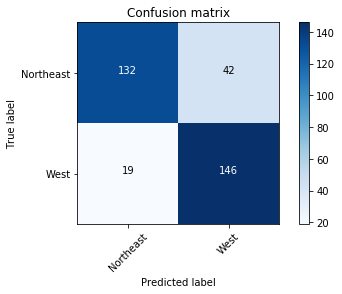

In [47]:
cm_forest = confusion_matrix(y_test, forest_test_pred)
plot_confusion_matrix(cm_forest, regions,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues)

In [48]:
print(classification_report(y_test, forest_test_pred))

              precision    recall  f1-score   support

           0       0.87      0.76      0.81       174
           1       0.78      0.88      0.83       165

    accuracy                           0.82       339
   macro avg       0.83      0.82      0.82       339
weighted avg       0.83      0.82      0.82       339



In [67]:
forest_metrics = get_metrics(forest_train_pred, forest_test_pred)
forest_metrics

,Accuracy (%),Precision (%),Recall (%),F1 Score (%)
Training Data,86.455696,82.550336,92.713568,86.396924
Testing Data,82.005900,77.659574,88.484848,81.955395


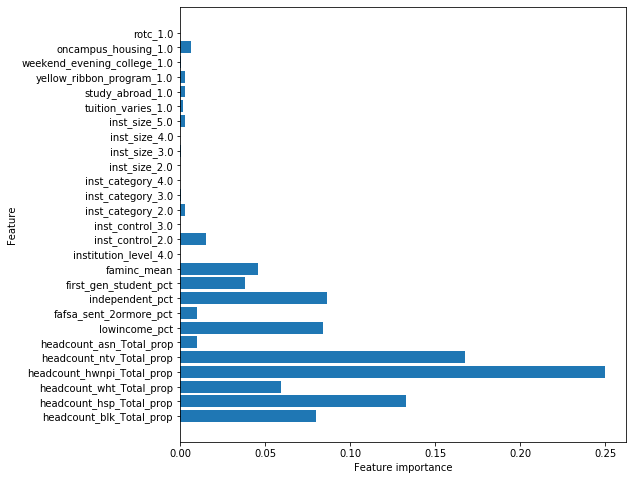

In [53]:
plot_feature_importances(forest.fit(X_train, y_train))

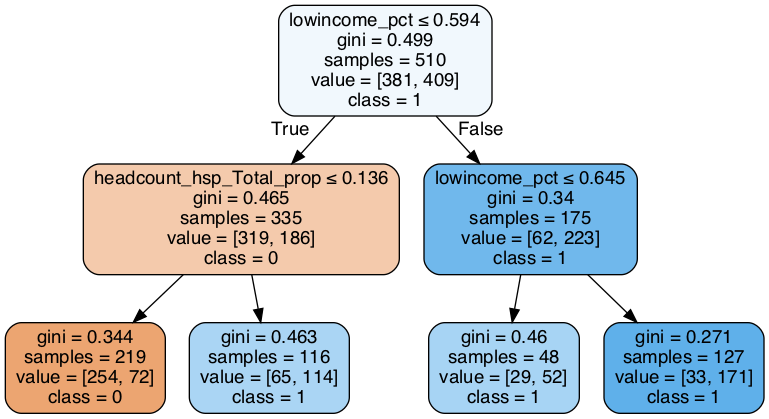

In [54]:
# Create DOT data
dot_data = export_graphviz(forest.estimators_[99], out_file=None, 
                           feature_names=X_test.columns,  
                           class_names=np.unique(y).astype('str'), 
                           filled=True, rounded=True, special_characters=True)

# Draw graph
graph = graph_from_dot_data(dot_data)  

# Show graph
Image(graph.create_png())

//anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


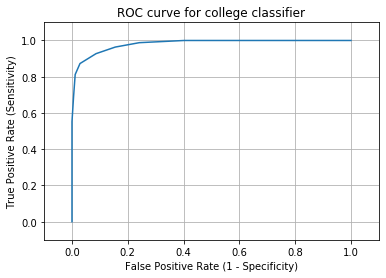

In [78]:
# First calculate the probability scores of each of the datapoints:
y_score = forest.fit(X_train, y_train).predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_score)
plt.plot(fpr, tpr)
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.title('ROC curve for college classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

## Optimize Random Forest Using GridSearchCV

In [56]:
forest = RandomForestClassifier(random_state = 42)

param_grid = {
    'n_estimators': [50, 100, 125, 150, 200],
    'criterion': ['gini', 'entropy'],
    'max_depth': [1, 2, 5, 8, 10],
    'min_samples_split': [2, 5, 10, 15, 20], 
    'max_features': [2, 'auto', 'log2']
}

gs_tree = GridSearchCV(forest, param_grid, cv=3)
gs_tree.fit(X_train, y_train)

gs_tree.best_params_

{'criterion': 'entropy',
 'max_depth': 10,
 'max_features': 'auto',
 'min_samples_split': 5,
 'n_estimators': 125}

## Random Forest (n_estimators = 125, max_depth = 10, min_samples_split = 5) (F1 = 0.93)

In [57]:
forest_opt = RandomForestClassifier(criterion = 'entropy', n_estimators = 125, 
                                    max_depth = 10, min_samples_split = 5, 
                                    random_state = 42)
forest_opt.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=10, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=125,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [68]:
forest_opt_train_pred = forest_opt.predict(X_train)
forest_opt_test_pred = forest_opt.predict(X_test)

Confusion Matrix, without normalization
[[163  11]
 [ 13 152]]


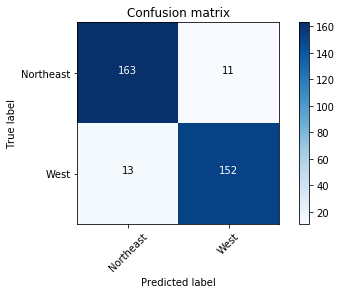

In [69]:
cm_forest_opt = confusion_matrix(y_test, forest_opt_test_pred)
plot_confusion_matrix(cm_forest_opt, regions,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues)

In [70]:
print(classification_report(y_test, forest_opt_test_pred))

              precision    recall  f1-score   support

           0       0.93      0.94      0.93       174
           1       0.93      0.92      0.93       165

    accuracy                           0.93       339
   macro avg       0.93      0.93      0.93       339
weighted avg       0.93      0.93      0.93       339



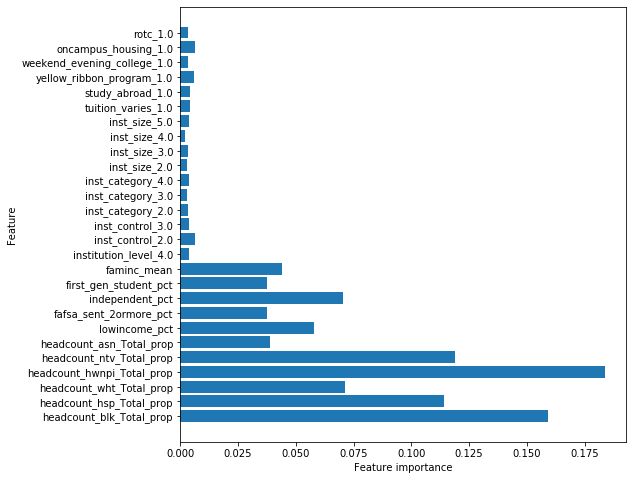

In [71]:
plot_feature_importances(forest_opt.fit(X_train, y_train))

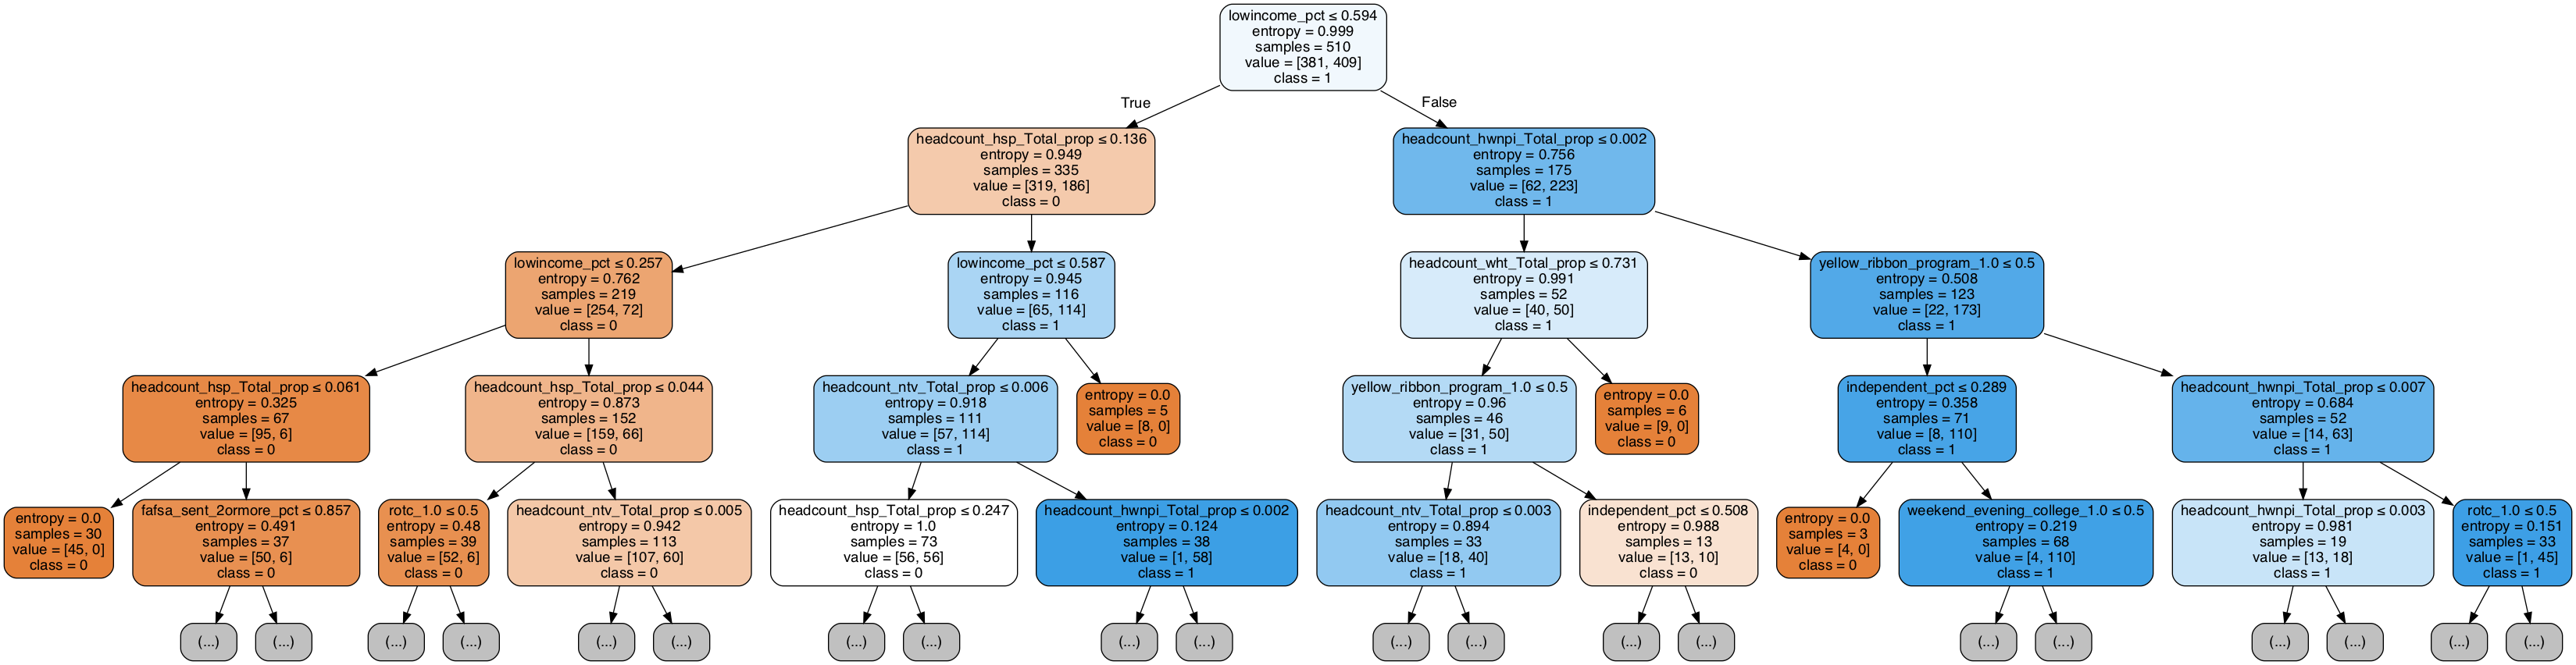

In [72]:
# Create DOT data
dot_data = export_graphviz(forest_opt.estimators_[99], out_file=None, 
                           feature_names=X_test.columns,  
                           class_names=np.unique(y).astype('str'), 
                           filled=True, rounded=True, special_characters=True, 
                           max_depth = 4)

# Draw graph
graph = graph_from_dot_data(dot_data)  

# Show graph
Image(graph.create_png())

In [74]:
forest_opt_metrics = get_metrics(forest_opt_train_pred, forest_opt_test_pred)
forest_opt_metrics

,Accuracy (%),Precision (%),Recall (%),F1 Score (%)
Training Data,99.873418,100.000000,99.748744,99.873419
Testing Data,92.920354,93.251534,92.121212,92.918997


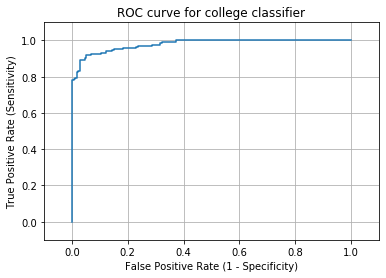

In [76]:
# Scikit-learn's built in roc_curve method returns the fpr, tpr, and thresholds
# for various decision boundaries given the case member probabilites

# First calculate the probability scores of each of the datapoints:
y_score = forest_opt.fit(X_train, y_train).predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_score)
plt.plot(fpr, tpr)
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.title('ROC curve for college classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)